# CPSC 330 hw5

**IMPORTANT NOTE:** This assignment, in its original form, is quite long. In Covid times, I am wary of overloading you. At the same time, I am also hesitant to delete useful material. My compromise is that I have marked some questions as optional and made them not part of your grade. If you have time, I recommend doing them! However, if you're short on time, you can skip them for now - later parts of the assignment don't depend on them. If you skip these questions, please look them over later as part of your exam studying - that content will still be fair game for exams. Solutions for these questions will be posted as part of the usual solutions posting.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Non-sklearn
from lightgbm import LGBMRegressor
import shap

# Add more imports below
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from scipy.stats import truncnorm

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()

    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

## Writing quality/quantity
rubric={points:5}

The TAs have reported a couple issues with the first few assignments: in some cases, submissions simply show the code output with no commentary; please write at least a sentence explaining your output in each question. In other cases, the TAs have come across multi-paragraph answers where a couple of sentences would have sufficed. Thus, we are now allocating the above points for well-structured answers of a reasonable length. In general, 1-3 sentences is good.

## Introduction

In this assignment we'll be exploring a [dataset](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data) of New York City Airbnb listings from 2019. As usual, you'll need to start by downloading the dataset.

In [4]:
df = pd.read_csv('AB_NYC_2019.csv')

In [5]:
df_train, df_test = train_test_split(df, random_state=123)

In [6]:
df_train.shape

(36671, 16)

In [7]:
df_train.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
31211,24240996,"new-entire condo, terrace, parking D-N-R train...",19707138,Ali,Brooklyn,Sunset Park,40.65604,-74.00032,Entire home/apt,125,15,1,2018-04-08,0.07,1,8
9605,7381236,Authentic Brownstone New York Living,33365473,Paul,Brooklyn,Bedford-Stuyvesant,40.68247,-73.94119,Entire home/apt,450,2,34,2019-04-26,0.76,2,337
41176,32036785,Big sunny room in Sunnyside,158126190,Oleg,Queens,Sunnyside,40.74141,-73.92688,Private room,33,7,2,2019-02-20,0.40,1,0
21795,17515870,Divided Room in Financial District,118753490,Yaodong,Manhattan,Financial District,40.70817,-74.00511,Private room,100,1,5,2017-04-30,0.17,1,0
38509,30296204,Brick and Beam Experience in North Williamsburg,1005966,Ryan,Brooklyn,Williamsburg,40.71980,-73.95813,Entire home/apt,300,3,7,2019-05-20,1.11,1,168


In this assignment we'll try to predict `reviews_per_month`, as a proxy for the popularity of the listing. Airbnb could use this sort of model to predict how popular future listings might be before they are posted, perhaps to help guide hosts create more appealing listings. In reality they might instead use something like vacancy rate or average rating as their target, but we do not have that available here.

I'll take care of some missing values for you here. 

- It seems that listings with 0 reviews have `reviews_per_month` set to NaN instead of 0.
- For listings without a listing name I set the name to the empty string.

In [8]:
df_train = df_train.fillna({"reviews_per_month" : 0, "name" : ""})
df_test  = df_test.fillna({"reviews_per_month" : 0, "name" : ""})

In [9]:
target_name = 'reviews_per_month'

In [10]:
X_train = df_train.drop(columns=[target_name])
y_train = df_train[target_name]

X_test  = df_test.drop(columns=[target_name])
y_test  = df_test[target_name]

In [11]:
y_train = y_train.fillna(value=0)
y_test  = y_test.fillna(value=0)

In [12]:
categorical_features = ['neighbourhood', 'neighbourhood_group', 'room_type']
drop_features        = ['id', 'name', 'host_id', 'host_name', 'last_review', 'number_of_reviews']
numeric_features     = ['latitude', 'longitude', 'price', 'minimum_nights', 'calculated_host_listings_count', 'availability_365']

Make sure all columns are accounted for:

In [13]:
assert sorted(X_train.columns) == sorted(categorical_features + drop_features + numeric_features)

Let's check for missing values (I already took care of some):

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36671 entries, 31211 to 15725
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              36671 non-null  int64  
 1   name                            36671 non-null  object 
 2   host_id                         36671 non-null  int64  
 3   host_name                       36653 non-null  object 
 4   neighbourhood_group             36671 non-null  object 
 5   neighbourhood                   36671 non-null  object 
 6   latitude                        36671 non-null  float64
 7   longitude                       36671 non-null  float64
 8   room_type                       36671 non-null  object 
 9   price                           36671 non-null  int64  
 10  minimum_nights                  36671 non-null  int64  
 11  number_of_reviews               36671 non-null  int64  
 12  last_review                 

It seems they are only present in `host_name` and `last_review`, both of which we are dropping, so we can skip imputation here.

In [15]:
preprocessor = ColumnTransformer([
    ('scale',  StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [16]:
preprocessor.fit(X_train);

In [17]:
ohe_feature_names = list(preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features))
new_columns = numeric_features + ohe_feature_names

In [18]:
X_train_enc = pd.DataFrame(preprocessor.transform(X_train).toarray(), index=X_train.index, columns=new_columns)

In [19]:
X_train_enc.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,...,neighbourhood_Woodrow,neighbourhood_Woodside,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
31211,-1.339822,-1.042322,-0.113896,0.377004,-0.185308,-0.795275,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9605,-0.854593,0.237836,1.238849,-0.239587,-0.154766,1.707105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
41176,0.227488,0.547645,-0.496827,-0.002437,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
21795,-0.382766,-1.146025,-0.217954,-0.287018,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
38509,-0.169250,-0.128914,0.614505,-0.192157,-0.185308,0.421688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Next, we'll try training some models:

In [20]:
dr = DummyRegressor()

In [21]:
pd.DataFrame(cross_validate(dr, X_train, y_train, return_train_score=True)).mean()

fit_time       0.015951
score_time     0.000199
test_score    -0.000103
train_score    0.000000
dtype: float64

Remember, the score here is the $R^2$. Let's try linear regression:

In [22]:
lr = make_pipeline(preprocessor, Ridge())

In [23]:
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True)).mean()

fit_time       0.244398
score_time     0.031209
test_score     0.098440
train_score    0.114548
dtype: float64

And a LightGBM regressor (using this because it runs much faster than `RandomForestRegressor`!):

In [24]:
lgbm = make_pipeline(preprocessor, LGBMRegressor())

In [25]:
cross_validate_std(lgbm, X_train, y_train, return_train_score=True)

fit_time           0.755740
score_time         0.087211
test_score         0.385951
train_score        0.479080
std_test_score     0.030012
std_train_score    0.005436
dtype: float64

## Exercise 1: data preparation

#### 1(a)
rubric={points:5}

Above I dropped the feature `number_of_reviews`. And yet, knowing the number of reviews seems quite useful in predicting the number of reviews per month. Why would it be problematic to leave this feature in?

**Answer:** Our goal is to use actual features of the property to predict `reviews_per_month` as a proxy for popularity. The `number_of_reviews` is simply another proxy for popularity, and not an actual feature of the property. Therefore, knowing the `number_of_reviews` is cheating in a way because it might minimize the influence of actual features in predicting popularity, and additionally inhibits our ability to gain an intuition of the most important predictors.

#### (optional) 1(b)

I noticed there were no missing values in the columns we're using, so I didn't put any imputation into the pipeline. In what scenario could that result in a problem down the line?

#### 1(c)
rubric={points:5}

After one-hot encoding, the number of columns increased significantly:

In [26]:
len(numeric_features) + len(categorical_features)

9

In [27]:
len(new_columns)

233

For each of the categorical variables printed below, how many new columns were generated?

In [28]:
categorical_features

['neighbourhood', 'neighbourhood_group', 'room_type']

In [29]:
for cf in categorical_features:
    print(cf + f': {len(X_train[cf].value_counts())}')

neighbourhood: 219
neighbourhood_group: 5
room_type: 3


**Answer:** If we define 'new' column as a one-hot-encoded column that didn't exist before:
- `neighbourhood` is transformed into 219 new columns
- `neighbourhood_group` is transformed into 5 new columns
- `room_type` is transformed into 3 new columns

This makes sense, because when added together, these produce 219 + 5 + 3 + 6 (`len(numeric_features)`) = 233 (`len(new_columns)`)

#### (optional) 1(d)

In the previous part you (hopefully) found that the vast majority of categories come from the "neighborhood" column. Let's look at how many of each category we have in the training set:

In [30]:
df_train['neighbourhood'].value_counts()

Williamsburg          2941
Bedford-Stuyvesant    2788
Harlem                1999
Bushwick              1840
Upper West Side       1502
                      ... 
Co-op City               1
Fort Wadsworth           1
Rossville                1
Woodrow                  1
Willowbrook              1
Name: neighbourhood, Length: 219, dtype: int64

Perhaps it doesn't make sense to have separate columns for some of these very rare cases. The code below modifies the preprocessor so that the categories are specified inside the `OneHotEncoder`. It uses the 30 most frequent neighbourhoods in the training set as the fixed categories.

In [31]:
categories = df_train['neighbourhood'].value_counts()[:30].index.values
categories

array(['Williamsburg', 'Bedford-Stuyvesant', 'Harlem', 'Bushwick',
       'Upper West Side', "Hell's Kitchen", 'East Village',
       'Upper East Side', 'Crown Heights', 'Midtown', 'Chelsea',
       'Greenpoint', 'East Harlem', 'Lower East Side',
       'Washington Heights', 'Astoria', 'West Village',
       'Financial District', 'Flatbush', 'Clinton Hill',
       'Long Island City', 'Prospect-Lefferts Gardens', 'Park Slope',
       'Fort Greene', 'East Flatbush', 'Kips Bay', 'Murray Hill',
       'Ridgewood', 'Flushing', 'Greenwich Village'], dtype=object)

In [32]:
categorical_features

['neighbourhood', 'neighbourhood_group', 'room_type']

In [33]:
preprocessor_cats = ColumnTransformer([
    ('scale',  StandardScaler(), numeric_features),
    ('ohe_cats', OneHotEncoder(handle_unknown='ignore', categories=[categories]), ["neighbourhood"]),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ["neighbourhood_group", "room_type"])
])

We then train two linear regression models with small `alpha` values, one with the original preprocessor and one with the modified preprocessor:

In [34]:
lr_small = make_pipeline(preprocessor, Ridge(0.01))
cross_validate_std(lr_small, X_train, y_train, return_train_score=True)

fit_time           0.260474
score_time         0.034764
test_score         0.097260
train_score        0.114827
std_test_score     0.013116
std_train_score    0.003532
dtype: float64

In [35]:
lr_small_cats = make_pipeline(preprocessor_cats, Ridge(0.01))
cross_validate_std(lr_small_cats, X_train, y_train, return_train_score=True)

fit_time           0.167100
score_time         0.029922
test_score         0.080835
train_score        0.084267
std_test_score     0.007148
std_train_score    0.001985
dtype: float64

In class I briefly mentioned that for our linear models (`LogisticRegression` and `Ridge`), having more features can be considered as having a more complex model because we have more coefficients. Given this, discuss the results above with respect to the fundamental tradeoff. Do the results align with your expectations?

-----------------

Earlier we dropped the `name` column, but perhaps the names contain useful information.

In [36]:
X_train["name"]

31211    new-entire condo, terrace, parking D-N-R train...
9605                  Authentic Brownstone New York Living
41176                          Big sunny room in Sunnyside
21795                   Divided Room in Financial District
38509      Brick and Beam Experience in North Williamsburg
                               ...                        
7763                      SUNNY ROOM A IN CHARMING AREA :)
15377               IDEAL One bedroom apt by Central Park!
17730                        Sunlit, spacious NY apartment
28030                                            One room.
15725                     Cozy Private Room w/ 1 Queen Bed
Name: name, Length: 36671, dtype: object

For example, maybe listings with the word "new" are more popular than listings with the word "rustic". Let's update the feature preprocessing so that `name` is not dropped, but instead encoded with `CountVectorizer`. Let's update the preprocessor:

In [37]:
preprocessor_text = ColumnTransformer([
    ('scale',  StandardScaler(), numeric_features),
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ('text', CountVectorizer(max_features=100, stop_words='english'), "name")
])

We can take a look at the transformed training data:

In [38]:
preprocessor_text.fit(X_train, y_train);

In [39]:
word_feature_names = ['name_' + word for word in preprocessor_text.named_transformers_['text'].get_feature_names()]
new_columns_text = new_columns + word_feature_names

In [40]:
X_train_enc_text = pd.DataFrame(data=preprocessor_text.transform(X_train).toarray(), columns=new_columns_text, index=X_train.index)
X_train_enc_text.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,...,name_townhouse,name_train,name_upper,name_uws,name_view,name_views,name_village,name_west,name_williamsburg,name_york
31211,-1.339822,-1.042322,-0.113896,0.377004,-0.185308,-0.795275,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9605,-0.854593,0.237836,1.238849,-0.239587,-0.154766,1.707105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
41176,0.227488,0.547645,-0.496827,-0.002437,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21795,-0.382766,-1.146025,-0.217954,-0.287018,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38509,-0.169250,-0.128914,0.614505,-0.192157,-0.185308,0.421688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We now have a lot of features generated by the OHE and the word counts:

In [41]:
ohe_feature_names[:20]

['neighbourhood_Allerton',
 'neighbourhood_Arden Heights',
 'neighbourhood_Arrochar',
 'neighbourhood_Arverne',
 'neighbourhood_Astoria',
 'neighbourhood_Bath Beach',
 'neighbourhood_Battery Park City',
 'neighbourhood_Bay Ridge',
 'neighbourhood_Bay Terrace',
 'neighbourhood_Bay Terrace, Staten Island',
 'neighbourhood_Baychester',
 'neighbourhood_Bayside',
 'neighbourhood_Bayswater',
 'neighbourhood_Bedford-Stuyvesant',
 'neighbourhood_Belle Harbor',
 'neighbourhood_Bellerose',
 'neighbourhood_Belmont',
 'neighbourhood_Bensonhurst',
 'neighbourhood_Bergen Beach',
 'neighbourhood_Boerum Hill']

In [42]:
word_feature_names[:20]

['name_1br',
 'name_2br',
 'name_amazing',
 'name_apartment',
 'name_apt',
 'name_artist',
 'name_astoria',
 'name_away',
 'name_backyard',
 'name_balcony',
 'name_bath',
 'name_bathroom',
 'name_beautiful',
 'name_bed',
 'name_bedroom',
 'name_best',
 'name_big',
 'name_bk',
 'name_br',
 'name_bright']

In fact, it seems we now have a feature called `neighbourhood_Williamsburg` and a feature called `name_williamsburg`:

In [43]:
X_train_enc_text[['neighbourhood_Williamsburg', 'name_williamsburg']]

,neighbourhood_Williamsburg,name_williamsburg
31211,0.0,0.0
9605,0.0,0.0
41176,0.0,0.0
21795,0.0,0.0
38509,1.0,1.0
...,...,...
7763,0.0,0.0
15377,0.0,0.0
17730,0.0,0.0
28030,0.0,0.0


#### 1(e)
rubric={points:5}

- What is the difference between our features  `neighbourhood_Williamsburg` and `name_williamsburg`? 
- Is it possible that one could be zero and the other nonzero?
- Is it redundant to have both?

**Answer:**
- The difference is:
 - `neighbourhood_Williamsburg` is a one-hot encoded column that contains a 1.0 if the `neighbourhood` column in the original dataset was the 'Williamsburg' category, 0.0 otherwise; whereas 
 - `name_williamsburg` is a count-vectorizer produced column that contains a number representing the *number of occurances* of the word 'williamsburg' in the `name` feature of the property
- It is possible that one is zero and the other is nonzero; a property `name` could contain 'williamsburg' (i.e. "Loft close to Williamsburg") without actually being in the 'Williamsburg' `neighbourhood`. In this case, `name_williamsburg` would be 1.0, but `neighbourhood_Williamsburg` would be 0.0.
- I think both features could be useful; in the example above, the presence of the word 'williamsburg' might still be useful, if the neighbourhood is close to the area but not categorically in it. Moreover, `CountVectorizer` (as used here), will show the number of occurances of this word in the name, which might provide more signal than just the presence or absence of 'williamsburg'.

#### (optional) 1(f)

Next, we explore the target values. The number of reviews per month ranges quite a bit:

In [44]:
y_train.describe()

count    36671.000000
mean         1.091355
std          1.611707
min          0.000000
25%          0.040000
50%          0.370000
75%          1.580000
max         58.500000
Name: reviews_per_month, dtype: float64

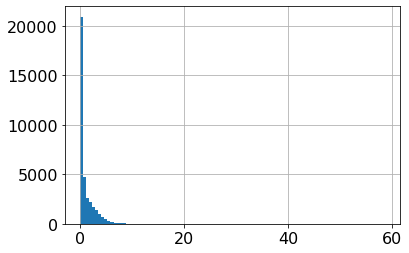

In [45]:
y_train.hist(bins=100);

We decide to log-transform these targets, because decide we care more about relative than absolute error:

In [46]:
y_train_log = np.log(y_train)
y_test_log  = np.log(y_test)

divide by zero encountered in log


ValueError: supplied range of [-inf, 4.069026754237811] is not finite

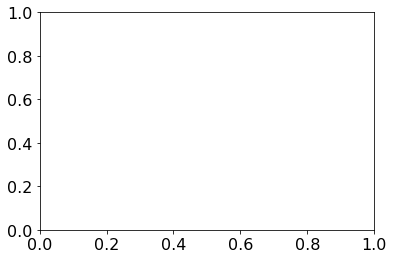

In [47]:
y_train_log.hist()

Oh no, an error!

- Explain the issue.
- Fix the issue.

## Exercise 2: model selection

#### 2(a)
rubric={points:15}

- Use `GridSearchCV` or `RandomizedSearchCV` to tune a `LGBMRegressor` pipeline on this problem, using `preprocessor_text` with un-transformed y-values. 
- Tune `num_leaves` of the `LGBMRegressor` and `max_features` of the `CountVectorizer` at least (you're welcome to include more hyperparameters if you want).
- What hyperparameters were chosen and what is the final score? 

In [48]:
# Adapted from Lecture 7

pipe = make_pipeline(preprocessor_text, LGBMRegressor())
hypers = {
    'lgbmregressor__num_leaves': [1, 10, 100, 1000],
    'columntransformer__text__max_features': [50, 100, 500, 1000],
}

searcher = GridSearchCV(pipe, hypers, verbose=1, n_jobs=-1, return_train_score=True)
searcher.fit(X_train, y_train)

columns = [
    'rank_test_score', 'mean_test_score', 'std_test_score', 'mean_train_score', 'param_lgbmregressor__num_leaves',  'param_columntransformer__text__max_features'
]
searcher_cv_results = pd.DataFrame(searcher.cv_results_)[columns].sort_values(by=['rank_test_score'])
searcher_cv_results

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished


,rank_test_score,mean_test_score,std_test_score,mean_train_score,param_lgbmregressor__num_leaves,param_columntransformer__text__max_features
14,1,0.396783,0.024597,0.633620,100,1000
2,2,0.396769,0.025721,0.632585,100,50
6,3,0.396733,0.025862,0.636537,100,100
10,4,0.396398,0.024440,0.634496,100,500
3,5,0.375074,0.021739,0.911865,1000,50
15,6,0.373843,0.020960,0.909168,1000,1000
11,7,0.373170,0.020422,0.909496,1000,500
7,8,0.369565,0.019565,0.913217,1000,100
1,9,0.367146,0.026140,0.403174,10,50
5,10,0.366375,0.025079,0.406349,10,100


In [49]:
print('\033[1m' + 'Answer:' + '\033[0m')
print(f'The value of num_leaves chosen is: {searcher_cv_results["param_lgbmregressor__num_leaves"].iloc[0]}')
print(f'The value of max_features chosen is: {searcher_cv_results["param_columntransformer__text__max_features"].iloc[0]}')
cv_score = searcher_cv_results["mean_test_score"].iloc[0]
print(f'The final mean cross-validation score on the validation fold is: {cv_score}')

Answer:
The value of num_leaves chosen is: 100
The value of max_features chosen is: 1000
The final mean cross-validation score on the validation fold is: 0.39678315545194087


#### 2(b)
rubric={points:5}

Briefly comment on the "error bars" from the different folds of cross-validation. Do you trust the ordering of the hyperparameters from the previous part? Briefly discuss.

**Answer:** After running cross-validation multiple times and experimenting with different values of $k$, the divergence of each fold from the mean (`std_test_score`) is on average 1% to 3% (depending on the hypers and value of $k$), which is relatively small. Across the hypers, the means are roughly close to the error bars of each other; but the mean validation score for `num_leaves=100` remains well within the error bars across changing values of `max_features`, and consistently higher than other values of `num_leaves`  across multiple runs of cross-validation with different values of $k$. This leads me to have some trust in selecting `num_leaves=100`, but to be more skeptical about definitively saying `max_features=1000` is best.

#### 2(c)
rubric={points:5}

Run your chosen pipeline on the test set. How does your test error compare to your cv error? Do you think you overfit the (cross-)validation set? Briefly discuss.

In [50]:
pipe = searcher.best_estimator_
pipe.fit(X_train, y_train)
test_score = pipe.score(X_test, y_test)
print('\033[1m' + 'Answer:' + '\033[0m')
print(f'After training on the full train set and testing with the test set, the score is {test_score}; roughly similar to the cross-validation score of {cv_score}. \nThe test score is within the error bars (+/- {searcher_cv_results["std_test_score"].iloc[0]}) of the cross-validation score, so we did not overfit on the cross-validation set; our validation score was representative of our score on unseen (test) data.')

Answer:
After training on the full train set and testing with the test set, the score is 0.3986183546278229; roughly similar to the cross-validation score of 0.39678315545194087. 
The test score is within the error bars (+/- 0.02459696836258267) of the cross-validation score, so we did not overfit on the cross-validation set; our validation score was representative of our score on unseen (test) data.


## Exercise 3: feature importances

For this exercise we'll consider the random forest created below, which performs somewhat decently (though still not great):

In [51]:
rf = RandomForestRegressor(max_depth=20, max_features=20, n_estimators=20, random_state=20)
rf_ttr = TransformedTargetRegressor(rf, func=np.log1p, inverse_func=np.expm1)
rf_ttr_pipe = make_pipeline(preprocessor_text, rf_ttr)

In [52]:
cross_validate_std(rf_ttr_pipe, X_train, y_train, return_train_score=True)

fit_time           6.762911
score_time         0.234367
test_score         0.239636
train_score        0.388895
std_test_score     0.015789
std_train_score    0.012848
dtype: float64

#### 3(a)
rubric={points:10}

Look at the feature importances for this random forest pipeline trained on the training set. What features seem to be driving your predictions most?

In [53]:
# Adapted from Lecture 11 and Piazza Post #338 (https://piazza.com/class/kb2e6nwu3uj23?cid=338)
rf_ttr_pipe.fit(X_train, y_train)
rf_importances = pd.DataFrame(data=rf_ttr_pipe[1].regressor_.feature_importances_, index=new_columns_text, columns=["Importance"]);
rf_importances.sort_values(by="Importance", ascending=False).head(10)

,Importance
availability_365,0.338560
minimum_nights,0.143188
longitude,0.059545
calculated_host_listings_count,0.051678
price,0.045092
latitude,0.041257
name_private,0.010044
room_type_Entire home/apt,0.009977
name_jfk,0.008690
room_type_Private room,0.008172


**Answer:** Given the results above (ordered from most important to least important), it seems that `availability_365` is the most important feature, `minimum_nights` is in second (about half as important), and `longditude`, `calculated_host_listings_count`, `price`, and `lattitude` are all minorly important after that. These results seem to make sense; as the `reviews_per_month` is probably correlated with how available the property is during the year, and how many people can visit the property in that time (based on `minimum_nights`).

#### 3(b)
rubric={points:5}

For the two most important features in the above model, do you think increasing these features increases or decreases the predicted number of reviews per month? Briefly justify your answer. **Maximum 2 sentences.**

Note: the results from part (a) don't tell you the answer here - I'm asking you to use your domain knowledge about short-term vacation rentals. What do you think makes a rental attractive?

**Answer:**
- I think *increasing* `availability_365` would lead the model to predict *more* `reviews_per_month`; if a rental is available more days of the year, it can be rented more and therefore reviewed more (and more flexibility is more attractive).
- I think *decreasing* `minimum_nights` would lead the model to predict *more* `reviews_per_month`if `minimum_nights` is lower, more people can rent and therefore review the property in the same amount of time (and more flexibility is more attractive).

#### 3(c)
rubric={points:10}

Use SHAP to try to answer the above question more definitively, for predictions on the training set. You will likely need to take a subset of the training examples for speed when computing the SHAP values. **Maximum 1 paragraph.**

In [54]:
# Adapted from Lecture 11
explainer = shap.TreeExplainer(rf_ttr_pipe[1].regressor_)
X_train_enc_text_sample = X_train_enc_text.sample(n=1000, random_state=123)

In [55]:
shap_values = explainer.shap_values(X_train_enc_text_sample)

Plot 1: SHAP importances for one example


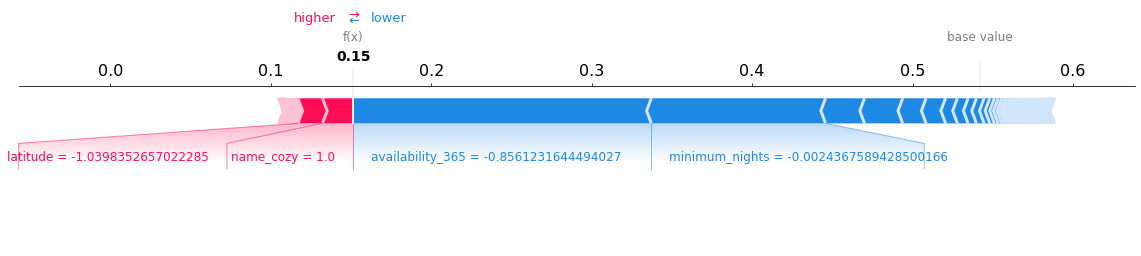

In [56]:
print('\033[1m' + 'Plot 1: SHAP importances for one example' + '\033[0m')
shap.force_plot(explainer.expected_value, shap_values[0], X_train_enc_text_sample.iloc[0], matplotlib=True)

Plot 2a: SHAP values for availability_365 vs. availability_365


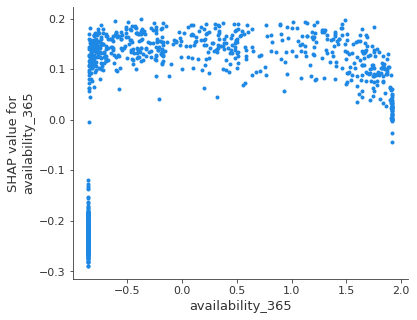

In [57]:
print('\033[1m' + 'Plot 2a: SHAP values for availability_365 vs. availability_365' + '\033[0m')
shap.dependence_plot('availability_365', shap_values, X_train_enc_text_sample, interaction_index=None)

Plot 2b: SHAP values for minimum_nights vs. minimum_nights


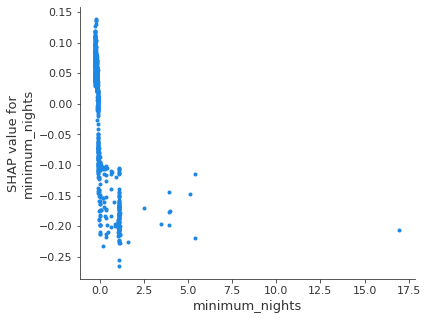

In [58]:
print('\033[1m' + 'Plot 2b: SHAP values for minimum_nights vs. minimum_nights' + '\033[0m')
shap.dependence_plot('minimum_nights', shap_values, X_train_enc_text_sample, interaction_index=None)

Plot 3: Summary of SHAP values for availability_365 and minimum_nights


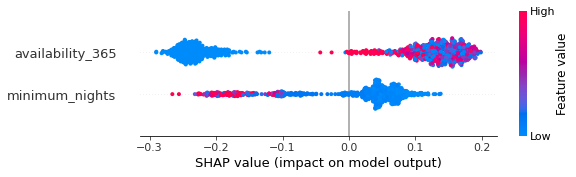

In [59]:
print('\033[1m' + 'Plot 3: Summary of SHAP values for availability_365 and minimum_nights' + '\033[0m')
shap.summary_plot(shap_values, X_train_enc_text_sample, max_display=2)

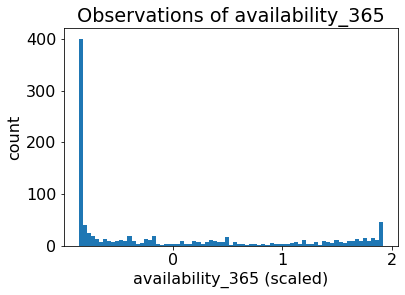

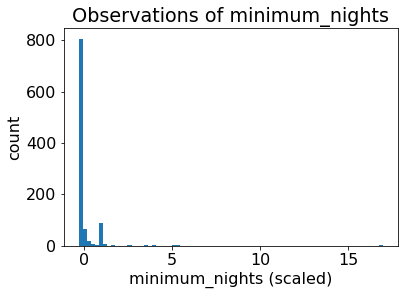

In [60]:
plt.hist(X_train_enc_text_sample['availability_365'], bins=75);
plt.title('Observations of availability_365')
plt.xlabel('availability_365 (scaled)')
plt.ylabel('count')
plt.show()
plt.hist(X_train_enc_text_sample['minimum_nights'], bins=75);
plt.title('Observations of minimum_nights')
plt.xlabel('minimum_nights (scaled)')
plt.ylabel('count');

**Answer:** For `availability_365`, a below-average observation pushed the target (`reviews_per_month`) lower (Plot 1) for one specific example. In aggregate, low values of `availability_365` sometimes push the target lower, sometimes higher (Plots 2a and 3). However, above-average values of `availability_365` overwhelmingly push the target higher (the red dots on the right side of Plot 3). For `minimum_nights`, below-average values tend to push the target higher, but sometimes lower (Plots 2b and 3). However, above-average values of `minimum_nights` overwhelmingly push the target lower (the red dots on the left side of Plot 3). That below-average values of `availability_365` and `minimum_nights` have an indeterminate effect on the target can be explained by the heavy right-skew of these distributions (see histograms above). Because they have far more values below the mean, it makes sense that these low values sometimes contribute positively and sometimes negatively, given that `RandomForestRegressor` is nonlinear.

#### (optional) 3(d)

The following code adds a column of random noise to `X` and re-trains.

In [61]:
random_noise = np.random.randn(X_train_enc_text.shape[0],1)
random_noise

array([[-0.62505675],
       [ 0.89199665],
       [-1.07377805],
       ...,
       [-1.04800769],
       [-0.26744311],
       [ 1.09517936]])

In [62]:
X_train_words_noise = pd.concat((X_train_enc_text, pd.DataFrame(random_noise, columns=['noise'], index=X_train_enc_text.index)), axis=1)
X_train_words_noise.head()

,latitude,longitude,price,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_Allerton,neighbourhood_Arden Heights,neighbourhood_Arrochar,neighbourhood_Arverne,...,name_train,name_upper,name_uws,name_view,name_views,name_village,name_west,name_williamsburg,name_york,noise
31211,-1.339822,-1.042322,-0.113896,0.377004,-0.185308,-0.795275,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.625057
9605,-0.854593,0.237836,1.238849,-0.239587,-0.154766,1.707105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.891997
41176,0.227488,0.547645,-0.496827,-0.002437,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.073778
21795,-0.382766,-1.146025,-0.217954,-0.287018,-0.185308,-0.856123,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.119233
38509,-0.169250,-0.128914,0.614505,-0.192157,-0.185308,0.421688,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.170050


In [63]:
rf_noise = RandomForestRegressor(max_depth=20, max_features=20, n_estimators=20, random_state=20)
rf_noise.fit(X_train_words_noise, y_train);

Next, we can look at the feature importances of this noise column:

In [64]:
pd.DataFrame(data=rf_noise.feature_importances_, index=X_train_words_noise.columns, columns=["Importance"]).tail()

,Importance
name_village,0.000924
name_west,0.001429
name_williamsburg,0.001045
name_york,0.001600
noise,0.036885


But wait, we know this feature can't possibly be useful - why is the importance of the random noise feature non-zero (and in fact larger than for some real features)?  **Maximum 2 sentences.**

#### 3(e)
rubric={points:10}

One of the numeric features is `price`, which is presumably in U.S. dollars per night. We can fit a `Ridge` model to the data and look at the coefficient corresponding to `price`. 

In [65]:
lr = make_pipeline(preprocessor_text, Ridge(alpha=100))
lr.fit(X_train, y_train);

In [66]:
coefs = pd.DataFrame(data=lr[1].coef_, index=new_columns_text, columns=["Coefficient"])
coefs.head()

,Coefficient
latitude,-0.057598
longitude,0.127302
price,-0.077215
minimum_nights,-0.194194
calculated_host_listings_count,-0.082677


In [67]:
price_coef = coefs.loc["price"].values[0]
price_coef

-0.07721474328961445

Normally, we can interpret a linear regression coefficient as the increase/decrease in the predicted target per unit change of the feature: for example, increasing the price by \\$1/night would decrease the predicted reviews/month by the above amount (decrease because of the negative coefficient).

However, that would be incorrect because we scaled the numeric features in the preprocessing pipeline, as discussed in lecture. 

In [68]:
scaler = preprocessor_text.named_transformers_['scale']

Taking into account the scaling, find the relationship implied by the model. Your answer should be in the units of (reviews per month) / (dollars per night); that is, your answer should be in the form of "Increasing the price by \$1 increases/decreases the predicted target by ___ reviews/month".


In [69]:
# Adapted from Lecture 11
delta = scaler.inverse_transform(np.ones(len(numeric_features))) - scaler.inverse_transform(np.zeros(len(numeric_features)))
lr_scales = pd.DataFrame(data=delta, index=numeric_features, columns=["Scale"])
lr_scales
unscaled_price_coef = price_coef/lr_scales.loc["price","Scale"]
print('\033[1m' + 'Answer:' + '\033[0m')
print(f'Increasing the price by $1/night decreases the predicted target (reviews/month) by {np.abs(unscaled_price_coef)} reviews/month.')

Answer:
Increasing the price by $1/night decreases the predicted target (reviews/month) by 0.0003213904198311367 reviews/month.


#### (optional) 3(f)

Perform an open-ended exploration of the feature importances using the model of your choosing. What is the most fun or interesting result you found? You could examine, for example:

- Different room types
- The importance of various numeric features
- The "most positive" and "most negative" words.

Recommended time spent: 5-15 min.

#### 3(g)
rubric={points:10}

Given your exploration in the previous part, can you draw conclusions about the world, such as the desireability of various neighbourhoods in New York? Could you now give advice to a friend on what words are best to use in an Airbnb listing? My answer, as you may have guessed, is no! (Or, at least, not without extreme caution and/or statistical training that goes beyond the scope of this course.) Give **3 reasons** why you might be wrong if you drew such conclusions about the world from the above analysis. **Maximum 1 sentence** per reason.

**Answer:**
1. Feature importances / coefficients are limited by the quantity and quality of training data; small datasets or those unrepresentative of the population could produce importances that fail to hold true in the real world.
2. Feature importances are heavily influenced by hyperparameters (such as a model's complexity and, and the number of words in its vocabulary), and therefore we can only use them to help our model given a set of hyperparameters; instead of directly applying it to reality.
3. Feature importances can sometimes be skewed by the inclusion of noisy variables that might appear to be predictive of (correlated with) the target in some way, but in reality bear no causal relationship with the target (as in Q3d).

## Exercise 4: very short answer questions
rubric={points:25}

Answer each of the following questions in **at most 1 sentence**. Each one is worth 5 points.

1. If `neighbourhood_group` is aready a feature, why might `neighbourhood` still be worth including?
2. If `neighbourhood` is aready a feature, why might `neighbourhood_group` still be worth including?
3. If you had an enormous training set and could only keep one of `neighbourhood` or `neighbourhood_group`, which one would you keep, and why?
4. How does the size of your training set influence how much you "trust" your feature importances?
5. If you wanted to find the "most positive" and "most negative" words in terms of reviews per month, would you use `Ridge` or `RandomForestRegressor`? Assume you're using only scikit-learn (no SHAP, etc.).


**Answer:**
1. Including `neighbourhood` might still be useful because assuming location is an important predictor in this domain, the model could use `neighbourhood` to more *granularly* predict popularity within a given part of New York (`neighborhood_group`).
2. Including `neighbourhood_group` might still be useful because if the data is imbalanced or there are very few examples with same `neighborhood`, the model could make better inferences by knowing `neighborhood_group`; a variable with fewer categories and more examples for each category. 
3. With an enormous training set, I would keep `neighborhood` (assuming sufficient examples for each category in a large training set), because it is a more specific and granular variable that I think will offer more nuanced signal.
4. A large training set (many examples) inspires greater trust in feature importances because in theory a larger sample is more representative of the actual population (law of large numbers).
5. If I wanted to find the most positive and most negative words, I would use `Ridge`, because it is a linear model and will produce positive/negative coefficients, whereas `RandomForestRegressor` is nonlinear so will only produce feature importances that represent the magnitude (not direction) of importance.

## Submission to Canvas

**IF YOU ARE WORKING WITH A PARTNER** please form the group before submitting - see instructions [here](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md#partners).

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below **or** by `File -> Export Notebook As... -> Export Notebook to HTML`.
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
>For this step, you will need a Canvas *Access Token* token. If you haven't already got one, log-in to Canvas, click `Account` (top-left of the screen), then `Settings`, then scroll down until you see the `+ New Access Token` button. Click that button, give your token any name you like and set the expiry date to Dec 31, 2020. Then click `Generate token`. Save this token in a safe place on your computer as you'll need it for all assignments. Treat the token with as much care as you would an important password. 

Note: for those having trouble with the Jupyter widgets and the dropdowns: if you add the argument `no_widgets=True` to your `submit` call, it should let you do a text-based entry of your key and avoid the dropdowns altogether. If this doesn't work, you probably need to upgrade to the latest version of `canvasutils` with `pip install canvasutils -U` from your terminal with your environment activated.


In [70]:
from canvasutils.submit import submit, convert_notebook

# Note: the canvasutils package should have been installed as part of your environment setup - 
# see https://github.com/UBC-CS/cpsc330/blob/master/docs/setup.md

In [74]:
# convert_notebook("hw5.ipynb", "html")  # uncomment and run when you want to try convert your notebook to HTML (or you can convert manually from the File menu)

Notebook successfully converted! 


In [75]:
submit(course_code=53561, token=False)  # uncomment and run when ready to submit 

Please paste your token here and then hit enter:


 ······································································



Token successfully entered - thanks!


Select an assignment to submit to:


Output()